# Homework 3 - data transformation & dimensionality reduction (deadline 18. 12. 2022, 23:59)

In short, the main task is to play with transformations and dimensionality reduction to obtain the best results for the linear regression model predicting house sale prices.
  
> The instructions are not given in detail: It is up to you to come up with ideas on how to fulfill the particular tasks as best you can!

However, we **strongly recommend and require** the following:
* Follow the assignment step by step. Number each step.
* Properly comment all your steps. Comments are evaluated for 2 points of the total together with the final presentation of the solution. However, it is not desirable to write novels! 
* Do not leave the task to the last minute.
* Hand in a notebook that has already been run (i.e. do not delete outputs before handing in).

## What are you supposed to do:

Your aim is to optimize the _RMSLE_ (see the note below) of the linear regression estimator (= our prediction model) of the observed sale prices.

**Just copied code from tutorial 3 and 5 will not be accepted.**

### Instructions:

  1. Download the dataset from the [course pages](https://courses.fit.cvut.cz/MI-PDD/homeworks/index.html) (data.csv, data_description.txt). It corresponds to [this Kaggle competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). 
  1. Transform features appropriately and prepare new ones - focus on the increase in the performance of the model (possibly in combination with further steps). Split the dataset into a train and test part exactly as we did in the tutorials. Use the test part for evaluation of the influence of further steps. _(3 points)_
  1. Try to find some suitable subset of features - first without the use of PCA. _(4 points)_
  1. Use PCA (principal component analysis) to reduce the dimensionality. Discuss the influence of the number of principal components. _(4 points)_
  1. Compare the results of previous steps on the test part of the dataset. _(3 points)_
  
Give comments (!) on each step of your solution, with short explanations of your choices.

All your steps and following code **have to be commented!** Comments are evaluated for _2 points_ together with the final presentation of the solution.

**If you do all this properly, you will obtain 16 points.**

**Note**: _RMSLE_ is a Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sale prices.


## Comments

  * Please follow the technical instructions from https://courses.fit.cvut.cz/NI-PDD/homeworks/index.html.
  * If the reviewing teacher is not satisfied, she can (!) give you another chance to rework your homework and to obtain more points. However, this is not a given, so do your best! :)
  * English is not compulsory.

In [1]:
import numpy as np
import pandas as pd
import math

from scipy import stats, optimize

from sklearn import model_selection, linear_model, metrics, preprocessing, feature_selection

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import PCA

from sklearn.feature_selection import RFE, RFECV

%matplotlib inline

In [2]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None)

In [3]:
RANDOM_STATE = 333

# Odstranění sloupců
Nejprve jsem odstranila několik příznaků, které nepřinášejí žádnou nebo minimální hodnotnou informaci. Jedná se o příznaky MiscFeature, MiscVal. Dále pak id (pro každý příznak jiná hodnota), PoolQC (pouze 7 vyplněných záznamů), Alley (pouze 91 vyplněných záznamů, navíc obsahují pouze dvě různé hodnoty), Street (pouze dva druhy hodnot z toho jedna zastoupena ppouze 2x).

In [4]:
df = pd.read_csv('data.csv')
display(df.head())
df.shape

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


(1460, 81)

In [5]:
df.MiscFeature.value_counts()

Shed    49
Gar2     2
Othr     2
TenC     1
Name: MiscFeature, dtype: int64

In [6]:
df.MiscVal.value_counts()

0        1408
400        11
500         8
700         5
450         4
600         4
2000        4
1200        2
480         2
15500       1
800         1
350         1
3500        1
1300        1
54          1
620         1
560         1
1400        1
8300        1
1150        1
2500        1
Name: MiscVal, dtype: int64

In [7]:
df.drop(['MiscVal', 'MiscFeature'], axis=1, inplace = True, errors = 'ignore')

In [8]:
display(df.head())
df.shape

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,12,2008,WD,Normal,250000


(1460, 79)

In [9]:
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,12.000000,2010.000000,755000.000000


In [10]:
# unikatni sloupec pro vsechny zaznamy
df.drop(['Id'], axis=1, inplace = True, errors = 'ignore')

In [11]:
# vyplneno pouhych 7 zaznamu
df.drop(['PoolQC'], axis=1, inplace = True, errors = 'ignore')

In [12]:
# vyplneno pouhych 91 zaznamu
# nabyva pouze 2 ruznych hodnot
df.Alley.value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

In [13]:
df.drop(['Alley'], axis=1, inplace = True, errors = 'ignore')

In [14]:
display(df.head())

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,12,2008,WD,Normal,250000


In [15]:
# obashuje pouze 2 velmi nerovnomerne zastoupene hodnoty
df.Street.value_counts()

Pave    1454
Grvl       6
Name: Street, dtype: int64

In [16]:
df.drop(['Street'], axis=1, inplace = True, errors = 'ignore')

## Přetypování object příznaků
Následně bylo potřeba přetypovat velké množství object příznaků, tak aby byly použitelné pro predikci. Z průzkumu dat a dokumentace příznaků vyplynulo, že velká řada object příznaků, může být brána jako příznaky ordinální (vyjadřují např. kvalitu něčeho, velikost apod.). Na zbylé příznaky jsem použila one hot encoding.

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   LotShape       1460 non-null   object 
 5   LandContour    1460 non-null   object 
 6   Utilities      1460 non-null   object 
 7   LotConfig      1460 non-null   object 
 8   LandSlope      1460 non-null   object 
 9   Neighborhood   1460 non-null   object 
 10  Condition1     1460 non-null   object 
 11  Condition2     1460 non-null   object 
 12  BldgType       1460 non-null   object 
 13  HouseStyle     1460 non-null   object 
 14  OverallQual    1460 non-null   int64  
 15  OverallCond    1460 non-null   int64  
 16  YearBuilt      1460 non-null   int64  
 17  YearRemodAdd   1460 non-null   int64  
 18  RoofStyl

In [18]:
types = {'Low' : 0, 'HLS' : 1, 'Bnk' : 2, 'Lvl' : 3,}

df['LandContour'] = df['LandContour'].map(lambda x: types[x])

In [19]:
types = {'ELO' : 0, 'NoSeWa' : 1, 'NoSewr' : 2, 'AllPub' : 3,}

df['Utilities'] = df['Utilities'].map(lambda x: types[x])

In [20]:
types = {'Sev' : 0, 'Mod' : 1, 'Gtl' : 2,}

df['LandSlope'] = df['LandSlope'].map(lambda x: types[x])

In [21]:
types = {'Po' : 0, 'Fa' : 1, 'TA' : 2, 'Gd' : 3, 'Ex' : 4}

df['ExterQual'] = df['ExterQual'].map(lambda x: types[x])
df['ExterCond'] = df['ExterCond'].map(lambda x: types[x])
df['HeatingQC'] = df['HeatingQC'].map(lambda x: types[x])
df['KitchenQual'] = df['KitchenQual'].map(lambda x: types[x])

In [22]:
types = {'NA' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5}

df['BsmtQual'] = df['BsmtQual'].fillna('NA')
df['BsmtQual'] = df['BsmtQual'].map(lambda x: types[x])

df['BsmtCond'] = df['BsmtCond'].fillna('NA')
df['BsmtCond'] = df['BsmtCond'].map(lambda x: types[x])

df['FireplaceQu'] = df['FireplaceQu'].fillna('NA')
df['FireplaceQu'] = df['FireplaceQu'].map(lambda x: types[x])

df['GarageQual'] = df['GarageQual'].fillna('NA')
df['GarageQual'] = df['GarageQual'].map(lambda x: types[x])

df['GarageCond'] = df['GarageCond'].fillna('NA')
df['GarageCond'] = df['GarageCond'].map(lambda x: types[x])

In [23]:
types = {'NA' : 0, 'No' : 1, 'Mn' : 2, 'Av' : 3, 'Gd' : 4}

df['BsmtExposure'] = df['BsmtExposure'].fillna('NA')
df['BsmtExposure'] = df['BsmtExposure'].map(lambda x: types[x])

In [24]:
types = {'NA' : 0, 'Unf' : 1, 'LwQ' : 2, 'Rec' : 3, 'BLQ' : 4, 'ALQ' : 5, 'GLQ' : 6}

df['BsmtFinType1'] = df['BsmtFinType1'].fillna('NA')
df['BsmtFinType1'] = df['BsmtFinType1'].map(lambda x: types[x])

df['BsmtFinType2'] = df['BsmtFinType2'].fillna('NA')
df['BsmtFinType2'] = df['BsmtFinType2'].map(lambda x: types[x])

In [25]:
types = {'N' : 0, 'Y' : 1}

df['CentralAir'] = df['CentralAir'].map(lambda x: types[x])

In [26]:
types = {'NA' : 0, 'Unf' : 1, 'RFn' : 2, 'Fin' : 3}

df['GarageFinish'] = df['GarageFinish'].fillna('NA')
df['GarageFinish'] = df['GarageFinish'].map(lambda x: types[x])

In [27]:
types = {'N' : 0, 'P' : 1, 'Y' : 2}

df['PavedDrive'] = df['PavedDrive'].map(lambda x: types[x])

In [28]:
types = {'NA' : 0, 'MnWw' : 1, 'GdWo' : 2, 'MnPrv' : 3, 'GdPrv' : 4}

df['Fence'] = df['Fence'].fillna('NA')
df['Fence'] = df['Fence'].map(lambda x: types[x])

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   LotShape       1460 non-null   object 
 5   LandContour    1460 non-null   int64  
 6   Utilities      1460 non-null   int64  
 7   LotConfig      1460 non-null   object 
 8   LandSlope      1460 non-null   int64  
 9   Neighborhood   1460 non-null   object 
 10  Condition1     1460 non-null   object 
 11  Condition2     1460 non-null   object 
 12  BldgType       1460 non-null   object 
 13  HouseStyle     1460 non-null   object 
 14  OverallQual    1460 non-null   int64  
 15  OverallCond    1460 non-null   int64  
 16  YearBuilt      1460 non-null   int64  
 17  YearRemodAdd   1460 non-null   int64  
 18  RoofStyl

## One hot encoding

In [30]:
df = pd.get_dummies(df)

In [31]:
df.shape

(1460, 218)

# Přetypování na float
Sjednotila jsem příznaky na datový typ float.

In [32]:
df[df.select_dtypes(['float64', 'int64']).columns] = df[df.select_dtypes(['float64', 'int64']).columns].astype('float64')

In [33]:
df.dtypes.value_counts()

uint8      163
float64     55
dtype: int64

# Doplnění NaN hodnot
NaN hodnoty jsem doplnila 0, vím že to není ideální, ale ukázalo se, že většina nevyplněných hodnot, představuje např, že daná místnost, nadstandard apod. v prodávaném domu chybí. Proto se nakonec doplnění 0 jevilo, jako ne uplně špatné řešení.

In [34]:
df = df.fillna(0)

# Rozdělení dat

In [35]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['SalePrice']), df['SalePrice'], 
                                                    test_size=0.25, random_state=RANDOM_STATE, shuffle=True)

In [36]:
# rozmery trenovaci a testovaci datove sady
display(X_train.shape)
display(X_test.shape)

(1095, 217)

(365, 217)

In [37]:
# zakladni popis target promenne
y_train.describe()

count      1095.000000
mean     180810.644749
std       80521.746166
min       34900.000000
25%      129900.000000
50%      162000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<AxesSubplot: >

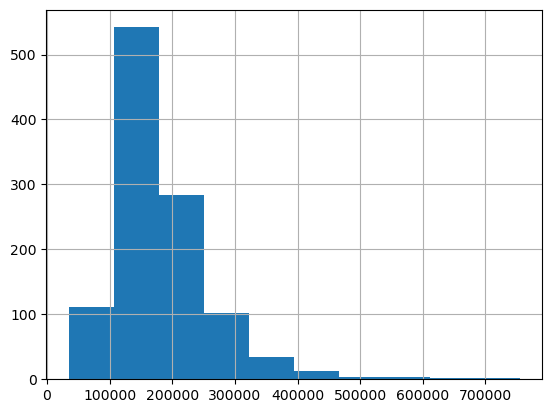

In [38]:
# target promenna vykazuje lognormalni rozdeleni
y_train.hist()

# Predikce na baseline datech
Prvotní predikce na původních datech.

In [39]:
# slovnik pro ukladani nejlepsich vysledku metod
all_results = {}

In [40]:
# funkce pro predikci a vyhodnoteni rmsle
def make_prediction(X_train, y_train, X_test, y_test):
    reg = linear_model.LinearRegression().fit(X_train, y_train)

    y_pred = reg.predict(X_test)
    # v nekterych pripadech doslo k predikci zapornych hodnot, ty byly nahrazeny hodnotou 0
    y_pred[y_pred < 0] = 0 
    rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
    return y_pred, rmsle

In [41]:
y_pred, rmsle_baseline = make_prediction(X_train, y_train, X_test, y_test)
all_results['baseline'] = rmsle_baseline

# vysledky na puvodni sade dat
print(rmsle_baseline)

0.1685971816627447


# Korelace s target proměnnou
Jako první způsob jsem zkusila ohodnotit příznaky pomocí Spearmanova korelačního koeficientu. Následně jsem vyzkoušela predikci s různým počtem top nejvíce korelujících příznaků s target proměnnou a výsledky vyhodnotila na testovacím datasetu. Na grafu níže je vidět rmsle vůči počtu příznaků.

In [42]:
# Spearman
corrS = pd.concat([X_train, y_train], axis=1).corr(method='spearman')

corrS_cols = corrS.SalePrice.abs().nlargest(len(X_train.columns)).index
display(corrS.SalePrice.loc[corrS_cols])

SalePrice                1.000000
OverallQual              0.811018
GrLivArea                0.732060
GarageCars               0.694658
ExterQual                0.694304
BsmtQual                 0.682851
KitchenQual              0.682729
YearBuilt                0.658139
GarageArea               0.652073
FullBath                 0.632322
GarageFinish             0.632210
GarageYrBlt              0.631618
TotalBsmtSF              0.605943
Foundation_PConc         0.587659
YearRemodAdd             0.576566
1stFlrSF                 0.569735
FireplaceQu              0.542633
TotRmsAbvGrd             0.540497
Fireplaces               0.518372
HeatingQC                0.500527
OpenPorchSF              0.483275
LotArea                  0.448411
GarageType_Detchd       -0.442888
GarageType_Attchd        0.441612
MasVnrArea               0.431553
MasVnrType_None         -0.416034
Foundation_CBlock       -0.384826
Exterior2nd_VinylSd      0.376401
Exterior1st_VinylSd      0.371692
MSZoning_RM   

In [43]:
# fce pro vykresleni vysledku rmsle vuci poctu priznaku
def plot_results(results, title):
    plt.subplots(1,1, figsize=(15, 7))
    results_l = len(results)
    ns = plt.scatter(range(0, results_l), results, c='blue')
    
    plt.xlabel('Počet sloupců')
    plt.ylabel('RMSLE')
    plt.title(f'{title}')
    
    plt.plot([0, results_l], [all_results['baseline'], all_results['baseline']])
   

In [44]:
def get_corr_results(X_train, y_train, X_test, y_test, max_to_omit):
    results = []
    for i in range(-1, -max_to_omit-1, -1):
        cols_to_omit = corrS.SalePrice.abs().nlargest(len(X_train.columns)).index[-1:i-1:-1]
        X_train_corr = X_train.drop(columns=corrS.SalePrice.loc[cols_to_omit].index)
        X_test_corr = X_test.drop(columns=corrS.SalePrice.loc[cols_to_omit].index)
        
        y_pred, rmsle = make_prediction(X_train_corr, y_train, X_test_corr, y_test)
        results.append(rmsle)
        
            
    plot_results(results, 'RMSLE pro různý počet vynechaných nejméně korelujících sloupců')
    
    min_rmsle = min(results)
    min_index = results.index(min_rmsle)
    all_results['corr'] = min_rmsle
    print(f'Nejmenší RMSLE vychází při odstranění {min_index} nejméně korelujících sloupců')
    print(f'Nejlepší RSMLE = {min_rmsle}')
    print(f'Baseline RMSLE = {rmsle_baseline}')
        
    return(results)

Nejmenší RMSLE vychází při odstranění 92 nejméně korelujících sloupců
Nejlepší RSMLE = 0.14980952394356545
Baseline RMSLE = 0.1685971816627447


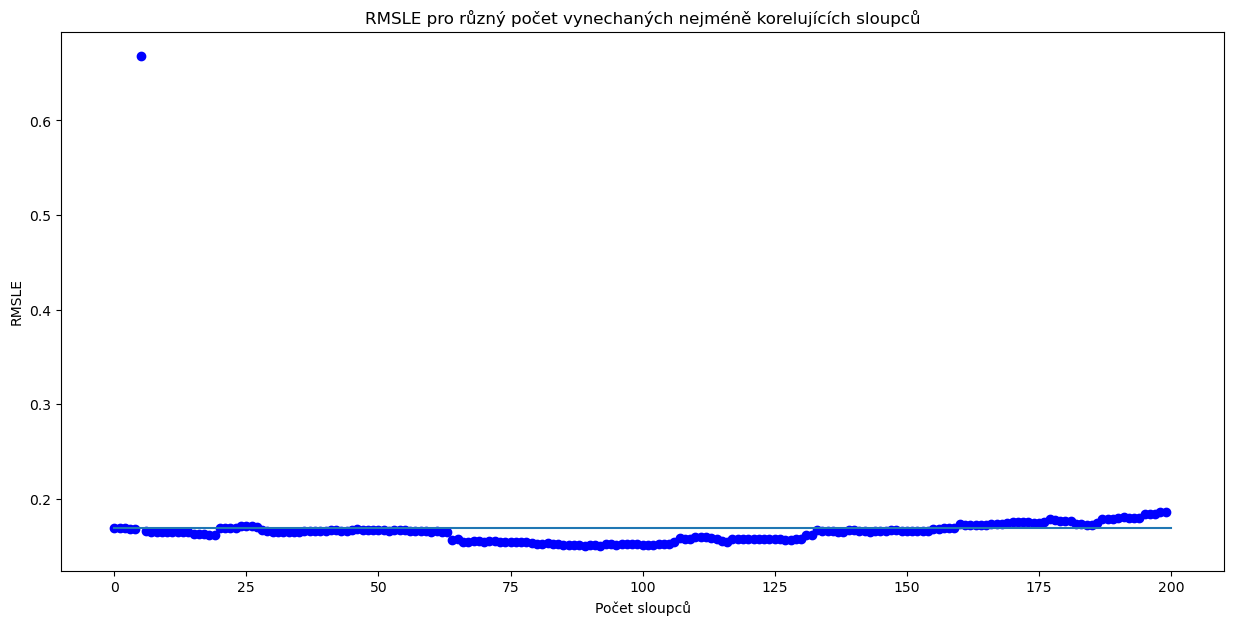

In [45]:
results = get_corr_results(X_train, y_train, X_test, y_test, max_to_omit=200)

In [46]:
results

[0.1685971816627516,
 0.16859718166274892,
 0.16859718166273632,
 0.1680659673039684,
 0.16806596730398057,
 0.6678854350689771,
 0.16553887465180187,
 0.16464492682064397,
 0.16464492682065646,
 0.16468187304815982,
 0.16465644179727715,
 0.1651322911549373,
 0.1651322911549264,
 0.1651322911548121,
 0.16441909817080064,
 0.162640336198658,
 0.16263937793299366,
 0.16260799420071045,
 0.16202728363223445,
 0.16198428880029753,
 0.16898043484756886,
 0.16898043484754638,
 0.1689804348475524,
 0.16877976156432747,
 0.1708041038065763,
 0.17080410380654493,
 0.17080410380654892,
 0.17046446075896066,
 0.16732352859992955,
 0.16584089111399078,
 0.16533510992169295,
 0.16533510992174824,
 0.16497700964311543,
 0.16470364541446703,
 0.1653379823458514,
 0.1650138873758071,
 0.1658999820643861,
 0.1659833399356245,
 0.16584240379661985,
 0.16581997516510974,
 0.1658528876254942,
 0.16700773285766998,
 0.16700773285769163,
 0.16555156888555084,
 0.16555141169354012,
 0.1669759485594721,
 0.1

## RFE

Jako další způsob jsem si vybrala Recursive Feature Elimination, jelikož se jedná o Wrapper metodu, rozdělila jsem původní trénovací sadu dat na trénovací a validační. RMSLE pro různé množství příznaků jsem poté měřila na validační sadě dat. Výsledné RMSLE pro počet příznaků, který vyšel nejlépe na validační sadě dat, jsem měřila na testovací sadě dat.

In [47]:
X_train_v, X_val, y_train_v, y_val = train_test_split(X_train, y_train, 
                                                    test_size=0.2, random_state=RANDOM_STATE, shuffle=True)

In [48]:
est = linear_model.LinearRegression()

In [49]:
def get_best_rfe(X_train, y_train, X_test, y_test):
    
    results = []
    
    for i in range(len(X_train.columns), 5, -1):
        rfe = RFE(
            estimator=est, n_features_to_select=i, step=1
        )
        rfe.fit(X_train, y_train)

        X_train_trans = rfe.transform(X_train)
        X_test_trans = rfe.transform(X_test)

        y_pred, rmsle = make_prediction(X_train_trans, y_train, X_test_trans, y_test)
        
        results.append(rmsle)
    
    plot_results(results, title = 'RMSLE v závislosti na počtu příznaků vyselktovaných pomocí RFE')
    
    min_rmsle = min(results)
    min_index = results.index(min_rmsle)
    
    print(f'Nejmenší RMSLE vychází při počtu {min_index} vybraných příznaků')
    print(f'Nejlepší RSMLE = {min_rmsle}')
    
    base_rmsle = all_results['baseline']
    print(f'Baseline RMSLE = {base_rmsle}')
    corr_rmsle = all_results['corr']
    print(f'Corr RMSLE = {corr_rmsle}')
        
    return results, min_index

Nejmenší RMSLE vychází při počtu 19 vybraných příznaků
Nejlepší RSMLE = 0.21472640688568043
Baseline RMSLE = 0.1685971816627447
Corr RMSLE = 0.14980952394356545


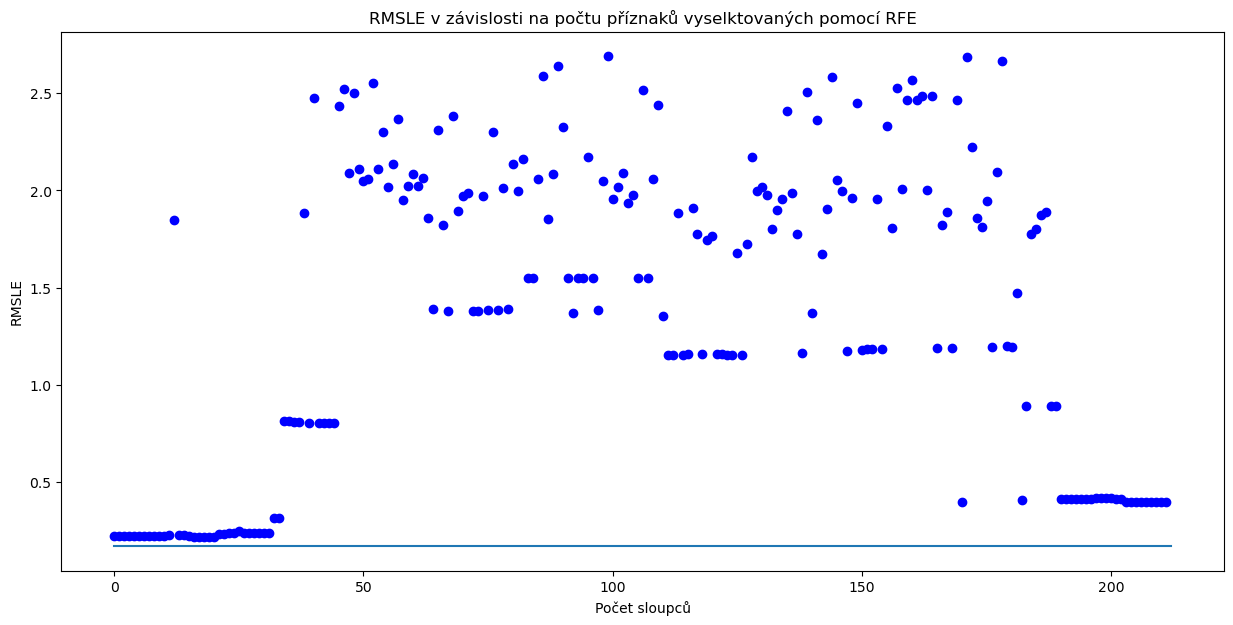

In [50]:
results, min_index = get_best_rfe(X_train_v, y_train_v, X_val, y_val)

In [51]:
results

[0.21889503364228155,
 0.2188950336422543,
 0.21889503364221022,
 0.2188950336423009,
 0.21889503364222937,
 0.21889503364226834,
 0.21889503364222007,
 0.21889503364225651,
 0.2188950336423559,
 0.21889503364223056,
 0.21889503364228785,
 0.22612206391798612,
 1.849197614515586,
 0.22639271711651693,
 0.22639271711651593,
 0.21967093340452032,
 0.21559885074186888,
 0.21483387526852818,
 0.21483387526853182,
 0.21472640688568043,
 0.2165767515132093,
 0.2309327382448106,
 0.23085986034780473,
 0.2382517033223916,
 0.23808371901938402,
 0.24525182698799472,
 0.2354825669140975,
 0.2354825669146928,
 0.23547950873624798,
 0.23878875354097834,
 0.2387887535406514,
 0.23858926989387985,
 0.31543690276882375,
 0.3154018584070083,
 0.811617117392671,
 0.8123149915563324,
 0.8067720550898883,
 0.8067721583207341,
 1.8862701615297257,
 0.8017493479153459,
 2.476240646707849,
 0.8046829368860867,
 0.8044832879755855,
 0.8044832879755858,
 0.8044825767651955,
 2.433610668265721,
 2.523860182326

In [52]:
# overeni vysledku na validacni sade dat
rfe = RFE(
            estimator=est, n_features_to_select=min_index, step=1
        )
rfe.fit(X_train_v, y_train_v)

X_train_trans = rfe.transform(X_train_v)
X_test_trans = rfe.transform(X_test)

y_pred, rmsle = make_prediction(X_train_trans, y_train_v, X_test_trans, y_test)

print(f'rmsle na testovaci sade dat = {rmsle} pri poctu {min_index} priznaku')
all_results['rfe'] = rmsle

rmsle na testovaci sade dat = 0.35251642916896436 pri poctu 19 priznaku


# PCA
Nakonec jsem vyzkoušela metodu PCA, kde jsem maximum komponent zafixovala na 200, na testovací sadě dat jsem poté měřila výsledky RMSLE pro různé počty komponent.

In [53]:
def get_best_comps(X_train, y_train, X_test, y_test):
    pca = PCA()
    pca.fit(X_train)
    
    X_train_trans = pca.transform(X_train)
    X_test_trans = pca.transform(X_test)
    
    results = []
    max_components = 200
    for n_comp in range(1, max_components):
        X_train_trans_sub = X_train_trans[:,0:n_comp]
        X_test_trans_sub = X_test_trans[:,0:n_comp]
        
        y_pred, rmsle = make_prediction(X_train_trans_sub, y_train, X_test_trans_sub, y_test)
        results.append(rmsle)
        
    plot_results(results, 'RMSLE v závislosti na počtu vybraných komponent pomocí PCA')
    
    min_rmsle = min(results)
    min_index = results.index(min_rmsle)
    all_results['pca'] = min_rmsle
    
    print(f'Nejmenší RMSLE vychází při počtu {min_index} komponent')
    print(f'Nejlepší RSMLE = {min_rmsle}')
    
    base_rmsle = all_results['baseline']
    print(f'Baseline RMSLE = {base_rmsle}')
    corr_rmsle = all_results['corr']
    print(f'Corr RMSLE = {corr_rmsle}')
    rfe_rmsle = all_results['rfe']
    print(f'Baseline RMSLE = {rfe_rmsle}')
    
    return results

Nejmenší RMSLE vychází při počtu 153 komponent
Nejlepší RSMLE = 0.15428093019377065
Baseline RMSLE = 0.1685971816627447
Corr RMSLE = 0.14980952394356545
Baseline RMSLE = 0.35251642916896436


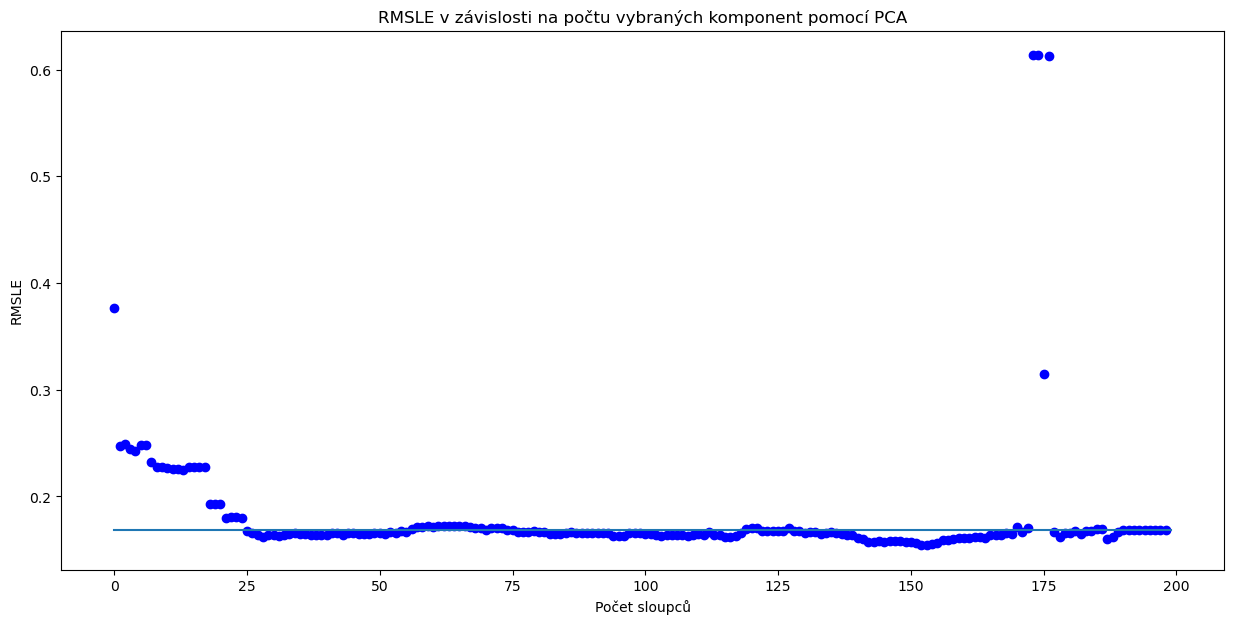

In [54]:
results = get_best_comps(X_train, y_train, X_test, y_test)

In [55]:
results

[0.37616302444867455,
 0.24760233619961508,
 0.24890313880879397,
 0.24420326171199128,
 0.24259599987481664,
 0.24847608943441998,
 0.24798126634832232,
 0.23252779954010752,
 0.22725008022463616,
 0.22746617745581052,
 0.22651458950585077,
 0.22599013005654073,
 0.2255467573269677,
 0.22527173455460064,
 0.22804763279795545,
 0.22728143323429775,
 0.22737312124704265,
 0.22783332445439047,
 0.19256368778620497,
 0.19297216318953309,
 0.19279620172976347,
 0.17959506472806766,
 0.18089635857086395,
 0.18037162846284863,
 0.17996374142736793,
 0.1672619661266875,
 0.16532925589120667,
 0.16355843951843524,
 0.16247066569711763,
 0.1640067846738859,
 0.1642710023103147,
 0.1626106193443721,
 0.16389493053536075,
 0.16527914986790304,
 0.16587525139856898,
 0.16446695986928042,
 0.16447553883603117,
 0.16431449725338318,
 0.1641487811785933,
 0.16392041605466134,
 0.1639428924104001,
 0.16577756206418018,
 0.16554861663619563,
 0.1639897761254268,
 0.166207721406147,
 0.16616468354961741

# Srovnání výsledků
Nejlepších výsledků bylo dosaženo při selekci příznaků na základě Spearmanova korelačního koeficientu. Druhá nejlepší se ukázala metoda PCA naopak nejhorších výsledků dosáhla metoda RFE.

In [56]:
all_results

{'baseline': 0.1685971816627447,
 'corr': 0.14980952394356545,
 'rfe': 0.35251642916896436,
 'pca': 0.15428093019377065}

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=15f1997a-84de-456d-a439-3cd6becfdc29' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>